In [ ]:
from google.colab import drive
drive.mount('/content/drive/',force_remount=False)
import os
os.chdir("/content/drive/MyDrive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


<h1>Intuit Upgrade</h1>

<table>
    <tr><td><b>TYPICAL TARGETING PROBLEM</b></td><td><b>INTUIT UPGRADING PROBLEM</d></td></tr>
    <tr><td>Mail to consumers in test sample</td><td>Mail consumers an upgrade offer</td></tr>
    <tr><td>Use consumer response to estimate model</td><td>Use consumer response to estimate model</td></tr>
    <tr><td>Use model to predict probability of response for rest of customers (i.e. those not in test sample)</td><td>Use model to predict probability of response for consumers who did not respond to initial upgrade offer</td></tr>
<tr><td>Is the reaction of the test sample a good predictor for reaction of the rest of customers?</td><td>Is the reaction to first offer a good predictor for reaction to second offer?</td></tr>
    <tr><td>Yes, assured by random sample.</td><td>Not necessarily, negative selection of customers.</td></tr>
</table>

Consequences:
<ul>
<li>
    <b>Lower response rate</b>: Discount estimated response rate by 50% ==> Divide Prob(response) by 2
<li>
    <b>Less external validity</b>: Particularly worried about overfitting. Err on simpler models.
</ul>

Two types of external validity issues:
<ul>
<li>
    <b>Small sample size</b>: validate outside of sample, p-values
<li>
    <b>World has changed</b>: business intuition, historical data, pilot tests. -- paricularly applicable to Wave 2.
</ul>


In [ ]:
import pandas
import mba263
import matplotlib.pyplot as plt

In [ ]:
data=pandas.read_csv('intuit.csv')

In [ ]:
data.shape
data.tail()


,id,sex,bizflag,zip,zip_bins,numords,dollars,last,sincepurch,version1,owntaxprod,upgraded,res1
19995,19996,M,0,99824,20,4,58.0,8,19,0,0,1,0
19996,19997,M,0,99835,20,1,22.0,17,2,0,0,0,0
19997,19998,M,0,99835,20,1,29.5,12,14,0,0,0,0
19998,19999,M,0,99901,20,2,111.5,19,22,0,0,1,0
19999,20000,M,0,99901,20,1,56.0,31,34,0,0,1,0


Reminder: what is version 1?

Dummy variable for whether customer currently has v1 (vs v2).


What is upgraded? 

Dummy variable for whether customer currently with v2 bought that version the first time or switched (upgraded!) from v1.

In [ ]:
data.groupby(['version1','upgraded'])['res1'].mean()

version1  upgraded
0         0           0.032370
          1           0.073284
1         0           0.065306
Name: res1, dtype: float64

## Let's start simple: Could we use RFM?

<Axes: xlabel='dollars_dec'>

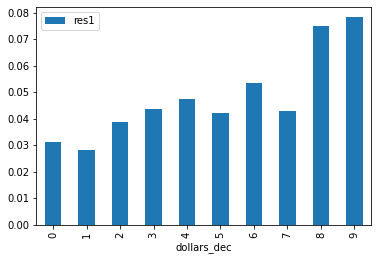

In [ ]:
data['dollars_dec']=mba263.ntile(data['dollars'],10)
data[['res1','dollars_dec']].groupby('dollars_dec').mean().plot(kind='bar')

<Axes: xlabel='freq_dec'>

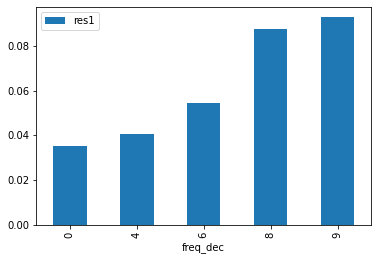

In [ ]:
data['freq_dec']=mba263.ntile(data['numords'],10)
data[['res1','freq_dec']].groupby('freq_dec').mean().plot(kind='bar')

2 different recency variables:

<Axes: xlabel='last_dec'>

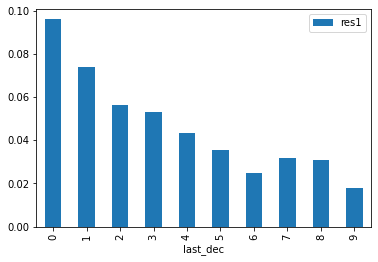

In [ ]:
data['last_dec']=mba263.ntile(data['last'],10)
data[['res1','last_dec']].groupby('last_dec').mean().plot(kind='bar')

<Axes: xlabel='rec_dec'>

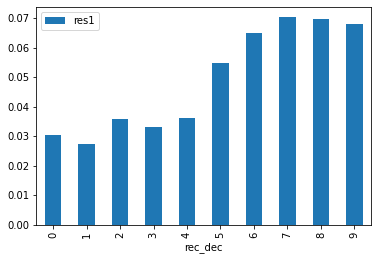

In [ ]:
data['rec_dec']=mba263.ntile(data['sincepurch'],10)
data[['res1','rec_dec']].groupby('rec_dec').mean().plot(kind='bar')

Let's construct RFM with different variable choices.

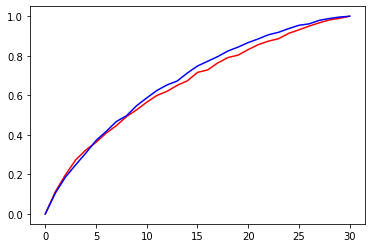

In [ ]:
data['rfm']=mba263.rfm_sq(data[['sincepurch','numords','dollars']],5)
data['p_rfm']=mba263.get_means(data['res1'],data['rfm'])
gains_rfm=mba263.gain(data['res1'],data['p_rfm'],30)
plt.plot(gains_rfm,'r')
data['rfm2']=mba263.rfm_sq(data[['last','numords','dollars']],5)
data['p_rfm2']=mba263.get_means(data['res1'],data['rfm2'])
gains_rfm=mba263.gain(data['res1'],data['p_rfm2'],30)
plt.plot(gains_rfm,'b')

# What targeting would we do?

## Remember: we don't use the baseline breakeven.  Specifically, we tell you to use a breakeven rate 2x of the baseline profitable breakeven point.

### In wave 1, we had a breakeven calculation with 2.35%, therefore we want to target customers with a response probability of $$2\times 2.35\% = 4.7\%$$


In [ ]:
(data['p_rfm']>0.0235*2).value_counts()

False    13140
True      6860
Name: p_rfm, dtype: int64

In [ ]:
(data['p_rfm']>0.0235*2).mean()

0.343

## What do our covariates tell us about responsiveness, using RFM to predict? Do we want to include these covariates (behavior, demos) in a model?

Gender categories - what is B? 

In [ ]:
pandas.crosstab(data['sex'],data['res1'],normalize='index')

res1,0,1
sex,,
B,0.931818,0.068182
F,0.957253,0.042747
M,0.949894,0.050106
U,0.954198,0.045802


In [ ]:
mba263.tabulate(data['sex'])

,Name,Count,Frequency
3,B,44,0.0022
2,F,4164,0.2082
1,M,13172,0.6586
0,U,2620,0.1310


Business vs home use?

In [ ]:
pandas.crosstab(data['bizflag'],data['res1'],normalize='index')

res1,0,1
bizflag,,
0,0.950437,0.049563
1,0.956628,0.043372


In [ ]:
cor, p = mba263.pwcorr(data[ ['res1','bizflag'] ])
p

,res1,bizflag
res1,0.000000,0.078513
bizflag,0.078513,0.000000


Past software version?

In [ ]:
pandas.crosstab(data['version1'],data['res1'],normalize='index')

res1,0,1
version1,,
0,0.956489,0.043511
1,0.934694,0.065306


In [ ]:
data.res1.value_counts()

0    19039
1      961
Name: res1, dtype: int64

In [ ]:
pandas.crosstab(data['version1'],data['upgraded'])

upgraded,0,1
version1,,
0,11523,4312
1,4165,0


In [ ]:
cor, p = mba263.pwcorr(data[ ['res1','version1'] ])
p

,res1,version1
res1,0.000000e+00,4.795348e-09
version1,4.795348e-09,0.000000e+00


Other software ownership?

In [ ]:
pandas.crosstab(data['owntaxprod'],data['res1'],normalize='index')

res1,0,1
owntaxprod,,
0,0.952410,0.047590
1,0.935424,0.064576


In [ ]:
cor, p = mba263.pwcorr(data[ ['res1','owntaxprod'] ])
cor

,res1,owntaxprod
res1,1.000000,0.012896
owntaxprod,0.012896,1.000000


What do we learn from updgrade status?

In [ ]:
pandas.crosstab(data['upgraded'],data['res1'],normalize='index')

res1,0,1
upgraded,,
0,0.958886,0.041114
1,0.926716,0.073284


In [ ]:
cor, p = mba263.pwcorr(data[ ['res1','upgraded'] ])
p

,res1,upgraded
res1,0.000000e+00,2.028926e-18
upgraded,2.028926e-18,0.000000e+00


## Construct dummy variables. I will include all levels, then I will drop one in the model variable list

In [ ]:
gender=pandas.get_dummies(data['sex'],prefix="sex")
zip_bins=pandas.get_dummies(data['zip_bins'],prefix="zip_bins")
data_with_dummies=pandas.concat([data,gender,zip_bins],axis=1)

In [ ]:
zip_bins.head()

,zip_bins_1,zip_bins_2,zip_bins_3,zip_bins_4,zip_bins_5,zip_bins_6,zip_bins_7,zip_bins_8,zip_bins_9,zip_bins_10,zip_bins_11,zip_bins_12,zip_bins_13,zip_bins_14,zip_bins_15,zip_bins_16,zip_bins_17,zip_bins_18,zip_bins_19,zip_bins_20
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
data_with_dummies.columns

Index(['id', 'sex', 'bizflag', 'zip', 'zip_bins', 'numords', 'dollars', 'last',
       'sincepurch', 'version1', 'owntaxprod', 'upgraded', 'res1',
       'dollars_dec', 'freq_dec', 'last_dec', 'rec_dec', 'rfm', 'p_rfm',
       'rfm2', 'p_rfm2', 'sex_B', 'sex_F', 'sex_M', 'sex_U', 'zip_bins_1',
       'zip_bins_2', 'zip_bins_3', 'zip_bins_4', 'zip_bins_5', 'zip_bins_6',
       'zip_bins_7', 'zip_bins_8', 'zip_bins_9', 'zip_bins_10', 'zip_bins_11',
       'zip_bins_12', 'zip_bins_13', 'zip_bins_14', 'zip_bins_15',
       'zip_bins_16', 'zip_bins_17', 'zip_bins_18', 'zip_bins_19',
       'zip_bins_20'],
      dtype='object')

We don't want to type the long list of variables over and over again, so I will define this handy list.

Note that I omitted sex=M and zip_bins=1.

In [ ]:
varlist=['dollars','last','sincepurch','owntaxprod','version1','upgraded','numords',
         'sex_F','sex_B','sex_U','bizflag',
         'zip_bins_2','zip_bins_3',
         'zip_bins_4','zip_bins_5','zip_bins_6',
         'zip_bins_7','zip_bins_8','zip_bins_9','zip_bins_10',
         'zip_bins_11',
         'zip_bins_12','zip_bins_13','zip_bins_14','zip_bins_15','zip_bins_16',
         'zip_bins_17','zip_bins_18','zip_bins_19','zip_bins_20']

In [ ]:
res=mba263.logit(data_with_dummies['res1'],data_with_dummies[varlist])
res.summary()

Optimization terminated successfully.
         Current function value: 0.170171
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                        Mba263Logit Regression Results                        
==============================================================================
Dep. Variable:                   res1   No. Observations:                20000
Model:                    Mba263Logit   Df Residuals:                    19969
Method:                           MLE   Df Model:                           30
Date:                Tue, 21 Mar 2023   Pseudo R-squ.:                  0.1171
Time:                        18:11:16   Log-Likelihood:                -3403.4
converged:                       True   LL-Null:                       -3854.7
Covariance Type:            nonrobust   LLR p-value:                1.835e-170
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.5088      0.135    -11.154      0.000      -1.774      -1.244
dollars         0.0010      0.000      2.446      0.014       0.000       0.002
last           -0.0519      0.004    -12.959      0.000      -0.060      -0.044
sincepurch      0.0064      0.006      0.999      0.318      -0.006       0.019
owntaxprod      0.0505      0.188      0.269      0.788      -0.318       0.419
version1        0.6581      0.141      4.672      0.000       0.382       0.934
upgraded        0.8045      0.138      5.844      0.000       0.535       1.074
numords         0.2107      0.031      6.862      0.000       0.151       0.271
sex_F          -0.1112      0.090     -1.237      0.216      -0.287       0.065
sex_B           0.7002      0.622      1.126      0.260      -0.519       1.919
sex_U           0.0060      0.111      0.054      0.957      -0.212       0.224
bizflag        -0.0921      0.087     -1.054      0.292      -0.263       0.079
zip_bins_2     -2.0447      0.184    -11.094      0.000      -2.406      -1.683
zip_bins_3     -2.0254      0.186    -10.890      0.000      -2.390      -1.661
zip_bins_4     -2.1785      0.194    -11.212      0.000      -2.559      -1.798
zip_bins_5     -1.9960      0.181    -11.018      0.000      -2.351      -1.641
zip_bins_6     -2.0928      0.186    -11.232      0.000      -2.458      -1.728
zip_bins_7     -1.9593      0.181    -10.811      0.000      -2.314      -1.604
zip_bins_8     -2.6290      0.232    -11.334      0.000      -3.084      -2.174
zip_bins_9     -1.9577      0.177    -11.068      0.000      -2.304      -1.611
zip_bins_10    -1.7610      0.167    -10.545      0.000      -2.088      -1.434
zip_bins_11    -2.0902      0.185    -11.320      0.000      -2.452      -1.728
zip_bins_12    -1.6074      0.160    -10.040      0.000      -1.921      -1.294
zip_bins_13    -2.1739      0.192    -11.319      0.000      -2.550      -1.797
zip_bins_14    -2.3360      0.207    -11.279      0.000      -2.742      -1.930
zip_bins_15    -1.8666      0.174    -10.758      0.000      -2.207      -1.527
zip_bins_16    -2.2166      0.199    -11.152      0.000      -2.606      -1.827
zip_bins_17    -2.1895      0.194    -11.262      0.000      -2.571      -1.808
zip_bins_18    -1.7962      0.170    -10.575      0.000      -2.129      -1.463
zip_bins_19    -2.1626      0.191    -11.348      0.000      -2.536      -1.789
zip_bins_20    -2.0490      0.186    -11.000      0.000      -2.414      -1.684
===============================================================================
"""

In [ ]:
mba263.odds_ratios(res)

,Odds ratios,std err,z,P>|z|,[0.025,0.975]
dollars,1.001025,0.000419,2.444576,0.015,1.000211,1.001838
last,0.949440,0.003801,13.301360,0.000,0.942065,0.956814
sincepurch,1.006433,0.006462,0.995541,0.319,0.993897,1.018970
owntaxprod,1.051801,0.197585,0.262169,0.793,0.668486,1.435115
version1,1.931073,0.272024,3.422764,0.001,1.403347,2.458799
upgraded,2.235628,0.307797,4.014424,0.000,1.638502,2.832754
numords,1.234541,0.037910,6.186850,0.000,1.160997,1.308086
sex_F,0.894772,0.080411,1.308625,0.191,0.738773,1.050770
sex_B,2.014162,1.252716,0.809570,0.418,-0.416107,4.444431
sex_U,1.006013,0.112061,0.053660,0.957,0.788616,1.223411


## What do we learn from all these zip code dummy variables?

In [ ]:
data.groupby('zip_bins')[['res1']].mean()

,res1
zip_bins,
1,0.217000
2,0.038922
3,0.038076
4,0.033865
5,0.041082
6,0.037924
7,0.041082
8,0.022044
9,0.043912


Try removing bizflag? It wasn't significant.

In [ ]:

varlist=['dollars','last','sincepurch','owntaxprod','version1','upgraded','numords',
         'sex_F','sex_B','sex_U',
         'zip_bins_1','zip_bins_3',
         'zip_bins_4','zip_bins_5','zip_bins_6',
         'zip_bins_7','zip_bins_8','zip_bins_9','zip_bins_10',
         'zip_bins_11',
         'zip_bins_12','zip_bins_13','zip_bins_14','zip_bins_15','zip_bins_16',
         'zip_bins_17','zip_bins_18','zip_bins_19','zip_bins_20']
res=mba263.logit(data_with_dummies['res1'],data_with_dummies[varlist])
mba263.odds_ratios(res)

Optimization terminated successfully.
         Current function value: 0.170199
         Iterations 8


,Odds ratios,std err,z,P>|z|,[0.025,0.975]
dollars,1.001024,0.000419,2.445325,0.014,1.000212,1.001837
last,0.949440,0.003801,13.302770,0.000,0.942067,0.956813
sincepurch,1.006497,0.006461,1.005438,0.315,0.993961,1.019032
owntaxprod,1.049742,0.197174,0.252275,0.801,0.667224,1.432260
version1,1.930207,0.271869,3.421522,0.001,1.402780,2.457633
upgraded,2.233285,0.307374,4.012323,0.000,1.636979,2.829592
numords,1.234595,0.037907,6.188649,0.000,1.161055,1.308135
sex_F,0.888476,0.079623,1.400658,0.161,0.734008,1.042944
sex_B,2.043617,1.270771,0.821247,0.412,-0.421679,4.508913
sex_U,0.967214,0.101621,0.322634,0.747,0.770068,1.164359


### Keep logit prediction for this model without bizflag... or do we want to drop more?

In [ ]:
data_with_dummies['p_logit1']=res.predict()

Targeting with this model?

In [ ]:
(data_with_dummies['p_logit1']>0.0235*2).mean()

0.3135

Let's compare to RFM!

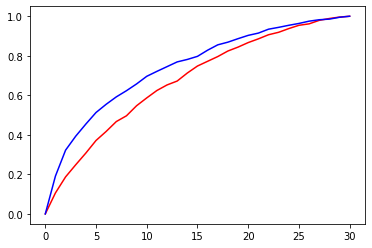

In [ ]:
gains_logit1=mba263.gain(data_with_dummies['res1'],data_with_dummies['p_logit1'],30)
plt.plot(gains_rfm,'r')
plt.plot(gains_logit1,'b')

## Try a neural net. 

(How did I choose layer sizes? )

In [ ]:
result_nn = mba263.neural_network(data_with_dummies['res1'],data_with_dummies[varlist],hidden_layer_sizes=(3,2))

In [ ]:
data_with_dummies['p_nn'] = result_nn.predict(data_with_dummies[varlist])

Compare NN to Logit.... bizarre prediction in the middle here

Does this matter?

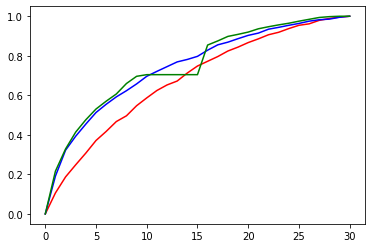

In [ ]:
gains_nn=mba263.gain(data_with_dummies['res1'],data_with_dummies['p_nn'],30)
plt.plot(gains_rfm,'r')
plt.plot(gains_logit1,'b')
plt.plot(gains_nn,'g')

In [ ]:
data_zip1=data_with_dummies[data_with_dummies['zip_bins_1']==1]

In [ ]:
pandas.crosstab(data_zip1['zip'],data_zip1['res1']).sort_values(by=1,ascending=False).head(10)

res1,0,1
zip,,
801,255,179
804,28,14
2146,8,2
2138,7,1
2161,1,1
2158,1,1
1772,1,1
1085,1,1
1105,1,1


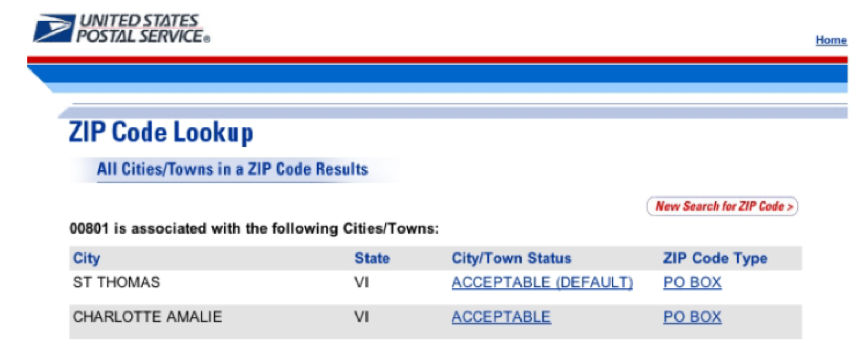

How else to know where to find this? Could run a model *only* with zip

In [ ]:
zip_model = mba263.neural_network(data['res1'],data[['zip']],hidden_layer_sizes=(10,10))
data['p_zip']=zip_model.predict(data[['zip']])
zip_gains=mba263.gain(data_with_dummies['res1'],data['p_zip'],30)


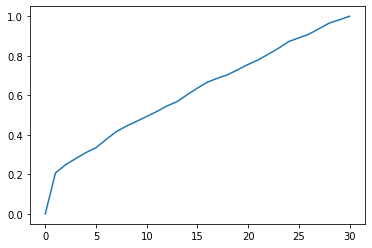

In [ ]:
plt.plot(zip_gains)

Zip mostly not-predictive after top groups... let's look closer.

In [ ]:
data.loc[data['p_zip']>data['p_zip'].quantile(0.95)]['zip'].value_counts()

801      434
804       42
0         38
2146      10
2138       8
        ... 
1730       2
1740       2
1741       2
1746       2
49506      2
Name: zip, Length: 209, dtype: int64

We will control for these 2 specific zip codes (could also do 0 if you like).

In [ ]:
data_with_dummies['801']=(data_with_dummies['zip']==801)*1

In [ ]:
data_with_dummies['804']=(data_with_dummies['zip']==804)*1

Check this doesn't supersede the original bins

In [ ]:
data_with_dummies.groupby('zip_bins_1')[['801','804']].mean()

,801,804
zip_bins_1,,
0,0.000,0.000
1,0.434,0.042


In [ ]:
varlist=['dollars','last','sincepurch','owntaxprod','version1','upgraded','numords',
         'sex_F','sex_B','sex_U',
         '804','801',
         'zip_bins_1','zip_bins_3',
         'zip_bins_4','zip_bins_5','zip_bins_6',
         'zip_bins_7','zip_bins_8','zip_bins_9','zip_bins_10','zip_bins_11',
         'zip_bins_12','zip_bins_13','zip_bins_14','zip_bins_15','zip_bins_16',
         'zip_bins_17','zip_bins_18','zip_bins_19','zip_bins_20']

Look at odds ratios for zip bins now that we controlled for these 2!

In [ ]:
res=mba263.logit(data_with_dummies['res1'],data_with_dummies[varlist])
mba263.odds_ratios(res)

Optimization terminated successfully.
         Current function value: 0.164605
         Iterations 8


,Odds ratios,std err,z,P>|z|,[0.025,0.975]
dollars,1.001173,0.000427,2.749727,0.006,1.000345,1.002000
last,0.948466,0.003885,13.263597,0.000,0.940928,0.956003
sincepurch,1.005283,0.006585,0.802333,0.422,0.992508,1.018058
owntaxprod,1.107050,0.209101,0.511951,0.609,0.701393,1.512706
version1,2.047160,0.294284,3.558339,0.000,1.476250,2.618071
upgraded,2.355665,0.330300,4.104348,0.000,1.714883,2.996446
numords,1.241507,0.038838,6.218326,0.000,1.166162,1.316853
sex_F,0.918169,0.083560,0.979301,0.327,0.756062,1.080276
sex_B,1.715653,1.124385,0.636484,0.524,-0.465654,3.896961
sex_U,0.956853,0.102354,0.421549,0.673,0.758285,1.155420


In [ ]:
data_with_dummies['p_logit2']=res.predict()

Compare gains.

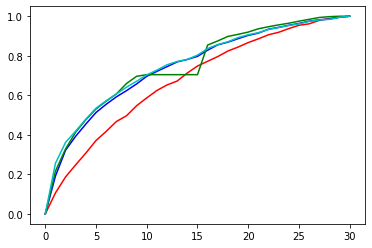

In [ ]:
gains_logit2=mba263.gain(data_with_dummies['res1'],data_with_dummies['p_logit2'],30)
plt.plot(gains_rfm,'r')
plt.plot(gains_logit1,'b')
plt.plot(gains_nn,'g')
plt.plot(gains_logit2,'c')

Neural net (without dummies for 801 and 804) was better than basic logit. Can we add some interactions?

In [ ]:
data_with_dummies['ver1_numords']=data_with_dummies['version1']*data_with_dummies['numords']

In [ ]:
data_with_dummies['ver1_last']=data_with_dummies['version1']*data_with_dummies['last']

In [ ]:
varlist=['dollars','last','sincepurch','owntaxprod','version1','upgraded','numords',
         'sex_F','sex_B','sex_U','bizflag',
         '804','801',
         'ver1_numords','ver1_last',
         'zip_bins_1','zip_bins_3',
         'zip_bins_4','zip_bins_5','zip_bins_6',
         'zip_bins_7','zip_bins_8','zip_bins_9','zip_bins_10','zip_bins_11',
         'zip_bins_12','zip_bins_13','zip_bins_14','zip_bins_15','zip_bins_16',
         'zip_bins_17','zip_bins_18','zip_bins_19','zip_bins_20']

In [ ]:
res=mba263.logit(data_with_dummies['res1'],data_with_dummies[varlist])
mba263.odds_ratios(res)

Optimization terminated successfully.
         Current function value: 0.162456
         Iterations 8


,Odds ratios,std err,z,P>|z|,[0.025,0.975]
dollars,1.001201,0.000430,2.793026,0.005,1.000367,1.002035
last,0.962777,0.004442,8.379726,0.000,0.954159,0.971395
sincepurch,1.005271,0.006623,0.795951,0.426,0.992423,1.018119
owntaxprod,1.206936,0.227677,0.908903,0.363,0.765243,1.648629
version1,1.808428,0.445360,1.815225,0.069,0.944430,2.672426
upgraded,2.344894,0.329990,4.075558,0.000,1.704713,2.985076
numords,1.139074,0.040715,3.415775,0.001,1.060087,1.218062
sex_F,0.944704,0.086581,0.638658,0.523,0.776738,1.112671
sex_B,1.678232,1.128131,0.601200,0.548,-0.510342,3.866805
sex_U,0.994844,0.113463,0.045443,0.964,0.774726,1.214962


In [ ]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Mba263Logit Regression Results                        
==============================================================================
Dep. Variable:                   res1   No. Observations:                20000
Model:                    Mba263Logit   Df Residuals:                    19965
Method:                           MLE   Df Model:                           34
Date:                Tue, 21 Mar 2023   Pseudo R-squ.:                  0.1571
Time:                        18:11:35   Log-Likelihood:                -3249.1
converged:                       True   LL-Null:                       -3854.7
Covariance Type:            nonrobust   LLR p-value:                1.656e-232
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -3.5626      0.209    -17.010      0.000      -3.973      -3.152
dollars          0.0012      0.000      2.795      0.005       0.000       0.002
last            -0.0379      0.005     -8.222      0.000      -0.047      -0.029
sincepurch       0.0053      0.007      0.798      0.425      -0.008       0.018
owntaxprod       0.1881      0.189      0.997      0.319      -0.182       0.558
version1         0.5925      0.246      2.406      0.016       0.110       1.075
upgraded         0.8522      0.141      6.056      0.000       0.576       1.128
numords          0.1302      0.036      3.643      0.000       0.060       0.200
sex_F           -0.0569      0.092     -0.621      0.535      -0.237       0.123
sex_B            0.5177      0.672      0.770      0.441      -0.800       1.835
sex_U           -0.0052      0.114     -0.045      0.964      -0.229       0.218
bizflag         -0.0870      0.089     -0.974      0.330      -0.262       0.088
804              2.2633      0.415      5.459      0.000       1.451       3.076
801              2.9421      0.239     12.323      0.000       2.474       3.410
ver1_numords     0.3213      0.059      5.469      0.000       0.206       0.437
ver1_last       -0.0656      0.010     -6.372      0.000      -0.086      -0.045
zip_bins_1       0.1696      0.271      0.625      0.532      -0.362       0.701
zip_bins_3       0.0072      0.237      0.031      0.976      -0.457       0.471
zip_bins_4      -0.1394      0.243     -0.573      0.567      -0.616       0.337
zip_bins_5       0.0342      0.233      0.147      0.883      -0.423       0.491
zip_bins_6      -0.0567      0.237     -0.239      0.811      -0.521       0.408
zip_bins_7       0.0592      0.233      0.254      0.800      -0.398       0.517
zip_bins_8      -0.5876      0.274     -2.142      0.032      -1.125      -0.050
zip_bins_9       0.0488      0.230      0.212      0.832      -0.402       0.500
zip_bins_10      0.2758      0.222      1.240      0.215      -0.160       0.712
zip_bins_11     -0.0691      0.236     -0.293      0.769      -0.531       0.393
zip_bins_12      0.4184      0.217      1.926      0.054      -0.007       0.844
zip_bins_13     -0.1586      0.242     -0.656      0.512      -0.632       0.315
zip_bins_14     -0.3118      0.254     -1.229      0.219      -0.809       0.185
zip_bins_15      0.1620      0.227      0.714      0.475      -0.283       0.607
zip_bins_16     -0.1943      0.247     -0.786      0.432      -0.678       0.290
zip_bins_17     -0.1866      0.244     -0.765      0.444      -0.665       0.292
zip_bins_18      0.2480      0.224      1.107      0.268      -0.191       0.687
zip_bins_19     -0.1424      0.240     -0.592      0.554      -0.613       0.329
zip_bins_20     -0.0072      0.237     -0.030      0.976      -0.471       0.457
================================================================================
"""

## I will show you one version of regularization: regularized logit, where we have a penalty parameter alpha which will throw away some variables for us.

In [ ]:
data_with_dummies['p_regularized_logit']=mba263.logit_reg(data_with_dummies['res1'],data_with_dummies[varlist],alpha=3).predict()

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.16444396331648578
            Iterations: 251
            Function evaluations: 257
            Gradient evaluations: 251


In [ ]:
mba263.odds_ratios(mba263.logit_reg(data_with_dummies['res1'],data_with_dummies[varlist],alpha=3))

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.16444396331648578
            Iterations: 251
            Function evaluations: 257
            Gradient evaluations: 251


,Odds ratios,std err,z,P>|z|,[0.025,0.975]
dollars,1.001207,0.000428,2.820895,0.005,1.000377,1.002037
last,0.961089,0.004416,8.810496,0.000,0.952522,0.969657
sincepurch,1.008528,0.006608,1.290444,0.197,0.995708,1.021348
owntaxprod,1.085351,0.211839,0.402905,0.687,0.674384,1.496319
version1,1.428547,0.351437,1.219414,0.223,0.746759,2.110334
upgraded,2.132492,0.298426,3.794880,0.000,1.553545,2.711439
numords,1.122501,0.039920,3.068659,0.002,1.045056,1.199946
sex_F,0.955568,0.084862,0.523581,0.601,0.790935,1.120201
sex_B,1.000000,NaN,NaN,NaN,NaN,NaN
sex_U,1.000000,NaN,NaN,NaN,NaN,NaN


In [ ]:
data_with_dummies['p_logit3']=res.predict()

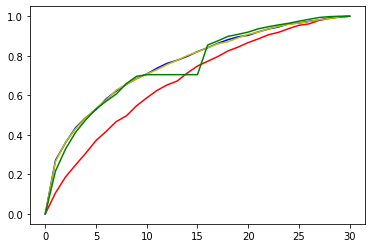

In [ ]:
gains_logit_reg=mba263.gain(data_with_dummies['res1'],data_with_dummies['p_regularized_logit'],30)
gains_logit3=mba263.gain(data_with_dummies['res1'],data_with_dummies['p_logit3'],30)
plt.plot(gains_rfm,'r')
plt.plot(gains_logit3,'b')
plt.plot(gains_logit_reg,'y')
plt.plot(gains_nn,'g')

The comparison is unfair because NN does not know 801, 804 variables. We also did not explicitly feed interactions (see comment below). Let's fix it and estimate NN using the same set of features and logit.

In [ ]:
varlist

['dollars',
 'last',
 'sincepurch',
 'owntaxprod',
 'version1',
 'upgraded',
 'numords',
 'sex_F',
 'sex_B',
 'sex_U',
 'bizflag',
 '804',
 '801',
 'ver1_numords',
 'ver1_last',
 'zip_bins_1',
 'zip_bins_3',
 'zip_bins_4',
 'zip_bins_5',
 'zip_bins_6',
 'zip_bins_7',
 'zip_bins_8',
 'zip_bins_9',
 'zip_bins_10',
 'zip_bins_11',
 'zip_bins_12',
 'zip_bins_13',
 'zip_bins_14',
 'zip_bins_15',
 'zip_bins_16',
 'zip_bins_17',
 'zip_bins_18',
 'zip_bins_19',
 'zip_bins_20']

In [ ]:
result_nn = mba263.neural_network(data_with_dummies['res1'],data_with_dummies[varlist],hidden_layer_sizes=(3,2))
data_with_dummies['p_nn2'] = result_nn.predict(data_with_dummies[varlist])
gains_nn2=mba263.gain(data_with_dummies['res1'],data_with_dummies['p_nn2'],30)

In [ ]:
result_nn_uf = mba263.neural_network(data_with_dummies['res1'],data_with_dummies[varlist],hidden_layer_sizes=(2,2))
data_with_dummies['p_nn_underfit'] = result_nn_uf.predict(data_with_dummies[varlist])
gains_nn_underfit=mba263.gain(data_with_dummies['res1'],data_with_dummies['p_nn_underfit'],30)

Let's try with a RF


In [ ]:
result_rf=mba263.random_forest(data_with_dummies['res1'],data_with_dummies[varlist],trees=1000,leaf_nodes=200)
data_with_dummies['p_rf'] = result_rf.predict(data_with_dummies[varlist])
gains_rf=mba263.gain(data_with_dummies['res1'],data_with_dummies['p_rf'],30)

In [ ]:
result_rf=mba263.random_forest(data_with_dummies['res1'],data_with_dummies[varlist],trees=1000,leaf_nodes=100)
data_with_dummies['p_rf_underfit'] = result_rf.predict(data_with_dummies[varlist])
gains_rf_u=mba263.gain(data_with_dummies['res1'],data_with_dummies['p_rf_underfit'],30)

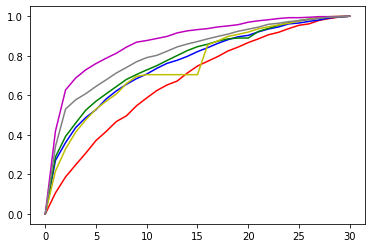

In [ ]:
plt.plot(gains_rfm,'r')
plt.plot(gains_logit3,'b')
plt.plot(gains_nn2,'g')
plt.plot(gains_nn,'y')
plt.plot(gains_rf,'m')
plt.plot(gains_rf_u,'grey')

In [ ]:
data_with_dummies.groupby('res1')['p_rf'].mean()

res1
0    0.038533
1    0.221387
Name: p_rf, dtype: float64

In [ ]:
data_with_dummies['p_final']=data_with_dummies['p_nn2']/2

In [ ]:
data_with_dummies['mail']=((data_with_dummies['p_final']>0.0235) & (data_with_dummies['res1']==0))*1

In [ ]:
mba263.tabulate(data_with_dummies['mail'])

,Name,Count,Frequency
0,0,15688,0.7844
1,1,4312,0.2156


### Compute predictions (with 50% response shading):
1) Mail all <br>
2) RFM <br>
3) Logit with zip bins <br>
4) Logit with zip bins and 2 specific zip dummies <br>
5) Logit with zip bins and interaction <br>
6) Regularized Logit <br>
7) Random Forest <br>
8) Random Forest - Underfit <br>
9) Neural net with zip bins <br>

In [ ]:
uniform_mail=(data_with_dummies['res1']==0).sum()
uniform_purch=int((data_with_dummies['res1']==0).sum()*(data_with_dummies['res1'].mean()*0.5))
uniform_response=(data_with_dummies['res1']==0).sum()*(data_with_dummies['res1'].mean()*0.5) / (data_with_dummies['res1']==0).sum()
uniform_profit=(60*int((data_with_dummies['res1']==0).sum()*(data_with_dummies['res1'].mean()*0.5))) -\
                      ((data_with_dummies['res1']==0).sum()*1.41)

In [ ]:
60*int((data_with_dummies['res1']==0).sum()*(data_with_dummies['res1'].mean()*0.5))

27420

In [ ]:
(data_with_dummies['res1']==0).sum()*1.41

26844.989999999998

In [ ]:
rfm_mail=((data_with_dummies['res1']==0)&(data_with_dummies['p_rfm']>(2*0.0235))).sum()
rfm_purch=int(0.5*data_with_dummies.loc[(data_with_dummies['res1']==0)&(data_with_dummies['p_rfm']>(2*0.0235)),'p_rfm'].sum())
rfm_response=(0.5*data_with_dummies.loc[(data_with_dummies['res1']==0)&(data_with_dummies['p_rfm']>(2*0.0235)),'p_rfm'].sum()) / \
  ((data_with_dummies['res1']==0)&(data_with_dummies['p_rfm']>(2*0.0235))).sum()
rfm_profit=int((60*0.5*data_with_dummies.loc[(data_with_dummies['res1']==0)&(data_with_dummies['p_rfm']>(2*0.0235)),'p_rfm'].sum())-
                     (((data_with_dummies['res1']==0)&(data_with_dummies['p_rfm']>(2*0.0235))).sum())*1.41)

In [ ]:
logit1_mail=((data_with_dummies['res1']==0)&(data_with_dummies['p_logit1']>(2*0.0235))).sum()
logit1_purch=int(0.5*data_with_dummies.loc[(data_with_dummies['res1']==0)&(data_with_dummies['p_logit1']>(2*0.0235)),'p_logit1'].sum())
logit1_response=(0.5*data_with_dummies.loc[(data_with_dummies['res1']==0)&(data_with_dummies['p_logit1']>(2*0.0235)),'p_logit1'].sum())/ \
                            ((data_with_dummies['res1']==0)&(data_with_dummies['p_logit1']>(2*0.0235))).sum()
logit1_profit=int((60*0.5*data_with_dummies.loc[(data_with_dummies['res1']==0)&(data_with_dummies['p_logit1']>(2*0.0235)),'p_logit1'].sum())-
                     (((data_with_dummies['res1']==0)&(data_with_dummies['p_logit1']>(2*0.0235))).sum())*1.41)

In [ ]:
logit2_mail=((data_with_dummies['res1']==0)&(data_with_dummies['p_logit2']>(2*0.0235))).sum()
logit2_purch=int(0.5*data_with_dummies.loc[(data_with_dummies['res1']==0)&(data_with_dummies['p_logit2']>(2*0.0235)),'p_logit2'].sum())
logit2_response=(0.5*data_with_dummies.loc[(data_with_dummies['res1']==0)&(data_with_dummies['p_logit2']>(2*0.0235)),'p_logit2'].sum())/ \
                            ((data_with_dummies['res1']==0)&(data_with_dummies['p_logit2']>(2*0.0235))).sum()
logit2_profit=int((60*0.5*data_with_dummies.loc[(data_with_dummies['res1']==0)&(data_with_dummies['p_logit2']>(2*0.0235)),'p_logit2'].sum())-
                     (((data_with_dummies['res1']==0)&(data_with_dummies['p_logit2']>(2*0.0235))).sum())*1.41)

In [ ]:
logit3_mail=((data_with_dummies['res1']==0)&(data_with_dummies['p_logit3']>(2*0.0235))).sum()
logit3_purch=int(0.5*data_with_dummies.loc[(data_with_dummies['res1']==0)&(data_with_dummies['p_logit3']>(2*0.0235)),'p_logit3'].sum())
logit3_response=(0.5*data_with_dummies.loc[(data_with_dummies['res1']==0)&(data_with_dummies['p_logit3']>(2*0.0235)),'p_logit3'].sum())/ \
                            ((data_with_dummies['res1']==0)&(data_with_dummies['p_logit3']>(2*0.0235))).sum()
logit3_profit=int((60*0.5*data_with_dummies.loc[(data_with_dummies['res1']==0)&(data_with_dummies['p_logit3']>(2*0.0235)),'p_logit3'].sum())-
                     (((data_with_dummies['res1']==0)&(data_with_dummies['p_logit3']>(2*0.0235))).sum())*1.41)

In [ ]:
reg_logit_mail=((data_with_dummies['res1']==0)&(data_with_dummies['p_regularized_logit']>(2*0.0235))).sum()
reg_logit_purch=int(0.5*data_with_dummies.loc[(data_with_dummies['res1']==0)&(data_with_dummies['p_regularized_logit']>(2*0.0235)),'p_regularized_logit'].sum())
reg_logit_response=(0.5*data_with_dummies.loc[(data_with_dummies['res1']==0)&(data_with_dummies['p_regularized_logit']>(2*0.0235)),'p_regularized_logit'].sum())/ \
                            ((data_with_dummies['res1']==0)&(data_with_dummies['p_regularized_logit']>(2*0.0235))).sum()
reg_logit_profit=int((60*0.5*data_with_dummies.loc[(data_with_dummies['res1']==0)&(data_with_dummies['p_regularized_logit']>(2*0.0235)),'p_regularized_logit'].sum())-
                     (((data_with_dummies['res1']==0)&(data_with_dummies['p_regularized_logit']>(2*0.0235))).sum())*1.41)

In [ ]:
rf_mail=((data_with_dummies['res1']==0)&(data_with_dummies['p_rf']>(2*0.0235))).sum()
rf_purch=int(0.5*data_with_dummies.loc[(data_with_dummies['res1']==0)&(data_with_dummies['p_rf']>(2*0.0235)),'p_rf'].sum())
rf_response=(0.5*data_with_dummies.loc[(data_with_dummies['res1']==0)&(data_with_dummies['p_rf']>(2*0.0235)),'p_rf'].sum())/ \
                            ((data_with_dummies['res1']==0)&(data_with_dummies['p_rf']>(2*0.0235))).sum()
rf_profit=int((60*0.5*data_with_dummies.loc[(data_with_dummies['res1']==0)&(data_with_dummies['p_rf']>(2*0.0235)),'p_rf'].sum())-
                     (((data_with_dummies['res1']==0)&(data_with_dummies['p_rf']>(2*0.0235))).sum())*1.41)

In [ ]:
rf_u_mail=((data_with_dummies['res1']==0)&(data_with_dummies['p_rf_underfit']>(2*0.0235))).sum()
rf_u_purch=int(0.5*data_with_dummies.loc[(data_with_dummies['res1']==0)&(data_with_dummies['p_rf_underfit']>(2*0.0235)),'p_rf_underfit'].sum())
rf_u_response=(0.5*data_with_dummies.loc[(data_with_dummies['res1']==0)&(data_with_dummies['p_rf_underfit']>(2*0.0235)),'p_rf_underfit'].sum())/ \
                            ((data_with_dummies['res1']==0)&(data_with_dummies['p_rf_underfit']>(2*0.0235))).sum()
rf_u_profit=int((60*0.5*data_with_dummies.loc[(data_with_dummies['res1']==0)&(data_with_dummies['p_rf_underfit']>(2*0.0235)),'p_rf_underfit'].sum())-
                     (((data_with_dummies['res1']==0)&(data_with_dummies['p_rf_underfit']>(2*0.0235))).sum())*1.41)

In [ ]:
nn_mail=((data_with_dummies['res1']==0)&(data_with_dummies['p_nn']>(2*0.0235))).sum()
nn_purch=int(0.5*data_with_dummies.loc[(data_with_dummies['res1']==0)&(data_with_dummies['p_nn']>(2*0.0235)),'p_nn'].sum())
nn_response=(0.5*data_with_dummies.loc[(data_with_dummies['res1']==0)&(data_with_dummies['p_nn']>(2*0.0235)),'p_nn'].sum())/ \
                            ((data_with_dummies['res1']==0)&(data_with_dummies['p_nn']>(2*0.0235))).sum()
nn_profit=int((60*0.5*data_with_dummies.loc[(data_with_dummies['res1']==0)&(data_with_dummies['p_nn']>(2*0.0235)),'p_nn'].sum())-
                     (((data_with_dummies['res1']==0)&(data_with_dummies['p_nn']>(2*0.0235))).sum())*1.41)

In [ ]:
nn2_mail=((data_with_dummies['res1']==0)&(data_with_dummies['p_nn2']>(2*0.0235))).sum()
nn2_purch=int(0.5*data_with_dummies.loc[(data_with_dummies['res1']==0)&(data_with_dummies['p_nn2']>(2*0.0235)),'p_nn2'].sum())
nn2_response=(0.5*data_with_dummies.loc[(data_with_dummies['res1']==0)&(data_with_dummies['p_nn2']>(2*0.0235)),'p_nn2'].sum())/ \
                            ((data_with_dummies['res1']==0)&(data_with_dummies['p_nn2']>(2*0.0235))).sum()
nn2_profit=int((60*0.5*data_with_dummies.loc[(data_with_dummies['res1']==0)&(data_with_dummies['p_nn2']>(2*0.0235)),'p_nn2'].sum())-
                     (((data_with_dummies['res1']==0)&(data_with_dummies['p_nn2']>(2*0.0235))).sum())*1.41)

In [ ]:
nn_u_mail=((data_with_dummies['res1']==0)&(data_with_dummies['p_nn_underfit']>(2*0.0235))).sum()
nn_u_purch=int(0.5*data_with_dummies.loc[(data_with_dummies['res1']==0)&(data_with_dummies['p_nn_underfit']>(2*0.0235)),'p_nn_underfit'].sum())
nn_u_response=(0.5*data_with_dummies.loc[(data_with_dummies['res1']==0)&(data_with_dummies['p_nn_underfit']>(2*0.0235)),'p_nn_underfit'].sum())/ \
                            ((data_with_dummies['res1']==0)&(data_with_dummies['p_nn_underfit']>(2*0.0235))).sum()
nn_u_profit=int((60*0.5*data_with_dummies.loc[(data_with_dummies['res1']==0)&(data_with_dummies['p_nn_underfit']>(2*0.0235)),'p_nn_underfit'].sum())-
                     (((data_with_dummies['res1']==0)&(data_with_dummies['p_nn_underfit']>(2*0.0235))).sum())*1.41)

Store these in a dataframe!

First I will put them in lists:

In [ ]:
models=['uniform','rfm','logit1','logit2','logit3','reg_logit','rf','rf_underfit','nn','nn2','nn_underfit']
mailed= [uniform_mail, rfm_mail,logit1_mail,logit2_mail,logit3_mail,reg_logit_mail,rf_mail, rf_u_mail,nn_mail, nn2_mail,nn_u_mail]
purch=[uniform_purch, rfm_purch,logit1_purch,logit2_purch,logit3_purch,reg_logit_purch,rf_purch, rf_u_purch,nn_purch, nn2_purch,nn_u_purch]
response = [uniform_response, rfm_response,logit1_response,logit2_response,logit3_response,reg_logit_response,rf_response, rf_u_response,nn_response, nn2_response,nn_u_response]
profit=[uniform_profit, rfm_profit,logit1_profit,logit2_profit,logit3_profit,reg_logit_profit,rf_profit, rf_u_profit,nn_profit, nn2_profit,nn_u_profit]

Then we can make these lists into a data frame and see it all together

In [ ]:
predictions=pandas.DataFrame({'Model':models,'Mailed':mailed,'Purchases':purch,'Response':response,'Profit':profit})
predictions

,Model,Mailed,Purchases,Response,Profit
0,uniform,19039,457,0.024025,575.01
1,rfm,6300,252,0.040006,6239.00
2,logit1,5622,269,0.047899,8230.00
3,logit2,5256,251,0.047781,7657.00
4,logit3,4707,239,0.050945,7750.00
5,reg_logit,4785,238,0.049797,7549.00
6,rf,3551,145,0.040896,3706.00
7,rf_underfit,3986,162,0.040672,4106.00
8,nn,4812,264,0.054939,9077.00
9,nn2,4312,239,0.055654,8318.00


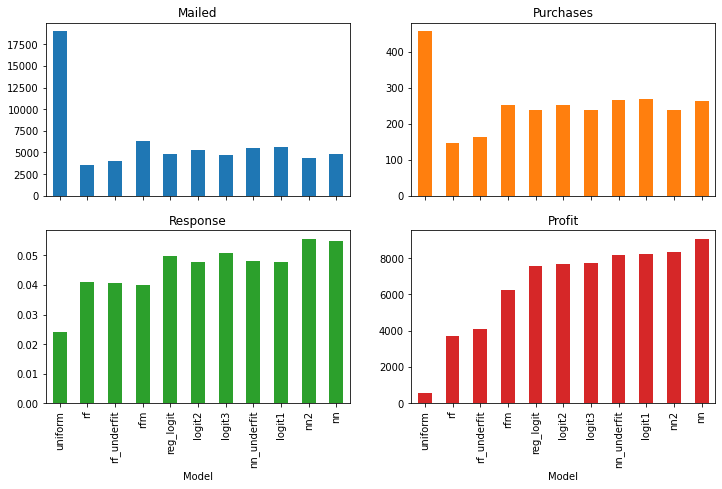

In [ ]:
predictions.groupby('Model').mean().sort_values('Profit').plot(kind='bar',subplots=True, figsize=(12, 7), layout=(2,2),
              sharex=True, sharey=False, legend=False)
plt.show()

<h2>Comment on using categorical variables in the NN models</h2>

It matters how you plug in categorical variables into models. This applies to machine learning models as well. In our case 'zip_bin' is a categorical variable.

Theoretically NN models should be able to learn "categories" from "numbers". In practice, we need to guide model by plugging categorical variables as dummies.

In [ ]:
varlist=['zip_bins']
result_nn = mba263.neural_network(data['res1'],data[varlist],hidden_layer_sizes=(5,5))
data['p_nn_naive'] = result_nn.predict(data[varlist])

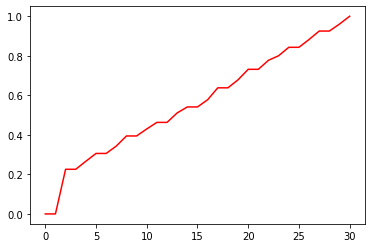

In [ ]:
gains_nn_naive=mba263.gain(data['res1'],data['p_nn_naive'],30)
plt.plot(gains_nn_naive,'r')

In [ ]:
varlist=['zip_bins_1','zip_bins_3',
         'zip_bins_4','zip_bins_5','zip_bins_6',
         'zip_bins_7','zip_bins_8','zip_bins_9','zip_bins_10','zip_bins_11',
         'zip_bins_12','zip_bins_13','zip_bins_14','zip_bins_15','zip_bins_16',
         'zip_bins_17','zip_bins_18','zip_bins_19','zip_bins_20']

In [ ]:
result_nn = mba263.neural_network(data_with_dummies['res1'],data_with_dummies[varlist],hidden_layer_sizes=(5,5))

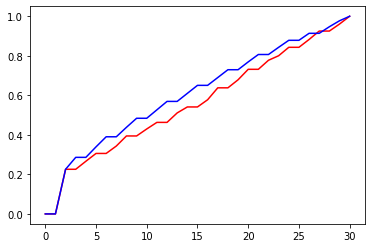

In [ ]:
data_with_dummies['p_nn_naive2'] = result_nn.predict(data_with_dummies[varlist])
gains_nn_naive2=mba263.gain(data_with_dummies['res1'],data_with_dummies['p_nn_naive2'],30)
plt.plot(gains_nn_naive,'r')
plt.plot(gains_nn_naive2,'b')

We obtain higher gain using neural network that is learning on the same data, but the data is presented differently. 

We need to create variables that highlight important features of the data to ease out learning. This applies particularly to complex unstructured data.